# Comparing Data From Different Sources

In this set of exercises we will attempt overlaying data from two sources:

1. keybiotopes_habitatgroups_shapefiles:
    - These shapefiles are the result of the last set of exercises analysing sksNyckelBiotoper_shapefiles. Both shapefiles display the locations and attributes of the key biotopes (Nyckelbiotoper) in Sweden.
    - Key-biotopes are high conservation value forests mapped by The Swedish Forest Agency though field surveys. A database of approximately 67 000 areas, consisting of polygons. A polygon represents an area that was determined to have high conservation value.

2. rutor_shapefiles:
    - This folder contains shapefiles for a specific (square-shaped) area in Sweden, for which laser measurements and satellite data are available.
    - The laser measurements are made using Lidar (light detection and ranging), an optical remote-sensing technique that uses laser light to densely sample the surface of the earth, producing highly accurate x, y, z measurements.
    - Lidar measurements are stored in `.laz` files. These files exist separately, but their names are registered in rutor_shape_files.

The overall goal is to use laser data (referenced in rutor_shapefiles) to study and identify key-biotopes (registered in sksNyckelBiotoper_shapefiles). So in this set of exercises we will find the intersection of these two datasets and study it.

# Read The Data

- To Do:

1. Import necessary libraries and read both keybiotopes_habitatgroups_shapefiles and rutor_shapefiles.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely as sh

In [2]:
laser_gdf = gpd.read_file("files/rutor_shapefiles/rutor.shp")
keybiotopes_gdf = gpd.read_file("files/keybiotopes_habitatgroups_shapefiles/keybiotopes_habitatgroups.shp")

# Explore and Filter

- To Do:
1. Explore the GeoDataFrames. What are the properties registered for the key-biotopes? What are the properties registered for the laser data?
        - Each key-biotope is identified by a code 'Beteckn'.
        - Each square-tile of laser data is identified by the coordinates of its south-west corner 'square'.

2. Can you figure out what columns of non-geometric data are not relevant? Drop them.

3. Before we can compare the geometries of these GeoDataFrames, we must make sure that the geometric objects are in the same coordinate system. (Use attributes `crs` attribute to read Coordinate Reference System)
        - We won't need this here, but in case the two CRS were different we could use module `pyproj` to convert one to another.

4. Laser measurements are provided for 2,5 km x 2,5 km square tiles. Check whether all of the tiles indeed have areas of 6.25 km$^2$.

In [3]:
laser_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21659 entries, 0 to 21658
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          21659 non-null  object  
 1   datum       21656 non-null  object  
 2   kommentar   0 non-null      object  
 3   flyghojd    21654 non-null  object  
 4   flyghastig  21653 non-null  object  
 5   overtackni  21653 non-null  object  
 6   punkttathe  21653 non-null  object  
 7   skannerid   21653 non-null  object  
 8   skannerfab  21653 non-null  object  
 9   skannermod  21653 non-null  object  
 10  oppningsvi  21653 non-null  object  
 11  pulsfrekve  21653 non-null  object  
 12  skanningsf  21653 non-null  object  
 13  uteffekt    21653 non-null  object  
 14  square      21659 non-null  object  
 15  Block       21659 non-null  object  
 16  SkannDat    21659 non-null  object  
 17  N           21659 non-null  object  
 18  E           21659 non-null  object  
 

In [4]:
laser_gdf.nunique() # columns with few unique values are most likely non informative.

id             1680
datum           147
kommentar         0
flyghojd          1
flyghastig        3
overtackni        3
punkttathe        4
skannerid         2
skannerfab        1
skannermod        1
oppningsvi        1
pulsfrekve        1
skanningsf        6
uteffekt          1
square        21659
Block           112
SkannDat        148
N               477
E               263
Las_Namn      21659
Skanner2          1
Region            1
LOV_AVL           2
geometry      21659
dtype: int64

In [6]:
uninforming_columns = [col for col in laser_gdf.columns if (laser_gdf[col].nunique() < 100)]

laser_gdf = laser_gdf.drop(columns = uninforming_columns) # drop the uninforming_columns
laser_gdf.head(4)

,id,datum,square,Block,SkannDat,N,E,Las_Namn,geometry
0,806,20180727,72900_8375_25,18H004,2018-07-27,7290000,837500,18H004_72900_8375_25.laz.laz,"POLYGON ((837500.000 7290900.000, 837500.000 7..."
1,616,20180718,73250_8725_25,18H006,2018-07-18,7325000,872500,18H006_73250_8725_25.laz.laz,"POLYGON ((874000.000 7325000.000, 873900.000 7..."
2,8502,20190826,69750_5500_25,19F010,2019-08-26,6975000,550000,19F010_69750_5500_25.laz.laz,"POLYGON ((551000.000 6977500.000, 551100.000 6..."
3,15712,20200329,65100_3175_25,20B022,2020-03-29,6510000,317500,20B022_65100_3175_25.laz.laz,"POLYGON ((318800.000 6510000.000, 318700.000 6..."


In [7]:
laser_gdf.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - onshore and offshore.
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
keybiotopes_gdf.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - onshore and offshore.
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [9]:
laser_gdf.loc[:,'geometry'].area.unique() # area in squared meters

array([6250000.])

## Plotting
- To Do:
1. Plot both geometries and then overlay them.
        - Use `GeoPandas` plot function

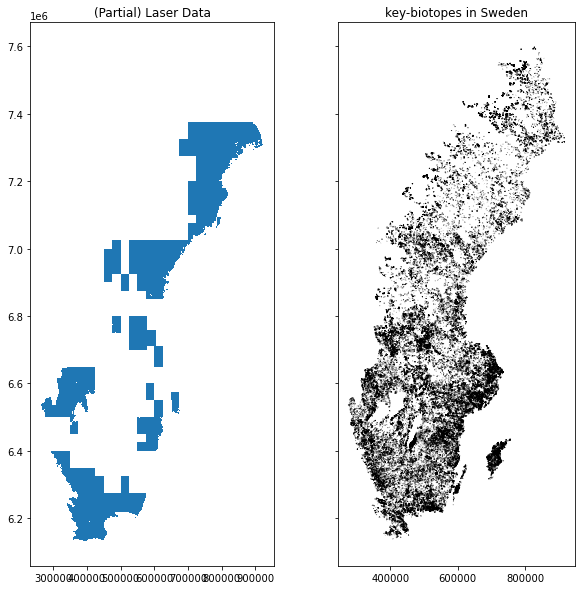

In [10]:
fig, axes = plt.subplots(1,2, figsize = (10,10), sharey = 'row')

laser_gdf.plot(ax = axes[0], facecolor = 'tab:blue')
keybiotopes_gdf.plot(ax = axes[1], facecolor = 'k', edgecolor = 'k')

axes[0].set_title('(Partial) Laser Data')
axes[1].set_title('key-biotopes in Sweden')
plt.show()

We can easily plot the two over each other.

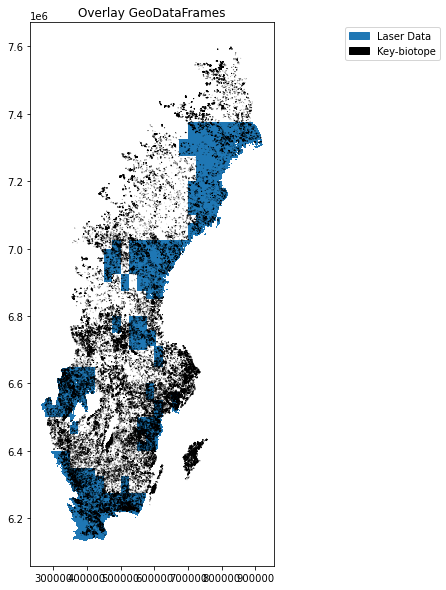

In [11]:
from matplotlib.patches import Patch

legend_elements = [Patch(color = 'tab:blue', label='Laser Data') , Patch(color = 'k', label='Key-biotope')]


fig, ax = plt.subplots(figsize = (5,10))

laser_gdf.plot(ax = ax)
keybiotopes_gdf.plot(ax = ax, facecolor = 'k', edgecolor = 'k')

ax.legend(handles = legend_elements, bbox_to_anchor = (1.7,1.0))
ax.set_title('Overlay GeoDataFrames')
plt.show()

# Intersection

The analysis we aim to -potentially- do will focus on the areas for which we have both kinds of data; ground surveys and laser measurement. In other words, the intersection of the plots we drew previously.

- To Do:
1. Get the intersection of the two GeoDataFrames' geometries.
        - use `GeoPandas` overlay function.
2. Get a GeoDataFrame of laser tiles that **don't** have key-biotopes.
3. How many square-tiles include key-biotopes? (i.e. how many squares-tiles are in the intersection?)
4. How many key-biotopes (of the total) are not covered by laser data (outside of the intersection)? What is the percentage of their area to the total?
        - You can add a new column to each GeoDataFrame, called 'Area' for example, and fill it using the attribute `.Area` applied to 'geometry'

In [12]:
intersection_gdf = gpd.overlay(laser_gdf, keybiotopes_gdf, how='intersection')

In [13]:
print(laser_gdf.shape)
print(keybiotopes_gdf.shape)

(21659, 9)
(66915, 24)


In [14]:
intersection_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29795 entries, 0 to 29794
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         29795 non-null  object  
 1   datum      29795 non-null  object  
 2   square     29795 non-null  object  
 3   Block      29795 non-null  object  
 4   SkannDat   29795 non-null  object  
 5   N          29795 non-null  object  
 6   E          29795 non-null  object  
 7   Las_Namn   29795 non-null  object  
 8   Beteckn    29795 non-null  object  
 9   LanKod     29795 non-null  object  
 10  Lan        29795 non-null  object  
 11  KommunKod  29795 non-null  object  
 12  Kommun     29795 non-null  object  
 13  Objnamn    25741 non-null  object  
 14  Hektar     29795 non-null  float64 
 15  Datinv     29795 non-null  object  
 16  Biotop1    29795 non-null  object  
 17  Biotop2    8118 non-null   object  
 18  Biotop3    173 non-null    object  
 19  Beskrivn1  26457 

In [15]:
# Laser tiles that include key-biotopes:
l = intersection_gdf.loc[:, 'square'].unique()

# Laser tiles that don't include key-biotopes:
ind = laser_gdf.loc[:,'square'].apply(lambda x: x not in l)

In [16]:
difference_gdf = laser_gdf.loc[ind]

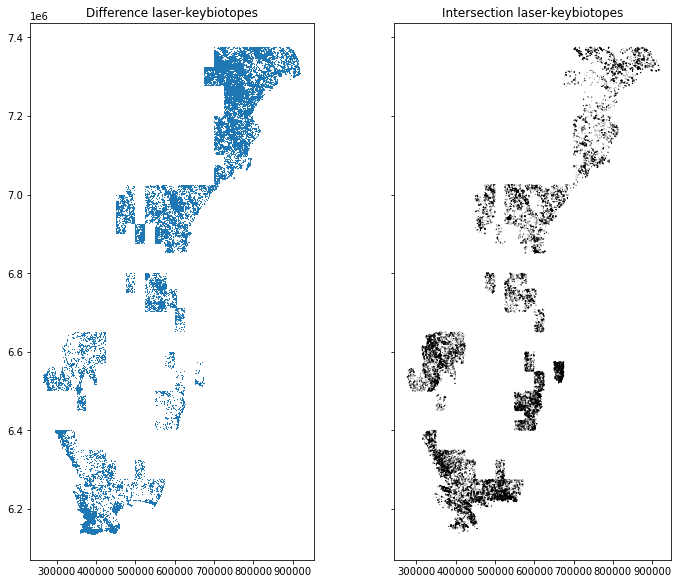

In [17]:
fig, axes = plt.subplots(1,2, figsize = (10,8), sharey = 'row', constrained_layout=True)

difference_gdf.plot(ax = axes[0], facecolor = 'tab:blue')
intersection_gdf.plot(ax = axes[1], facecolor = 'k', edgecolor = 'k')

axes[0].set_title('Difference laser-keybiotopes')
axes[1].set_title('Intersection laser-keybiotopes')
plt.show()

In [18]:
print('#square-tiles which include key-biotopes = ', intersection_gdf.square.nunique())

#square-tiles which include key-biotopes =  9607


In [19]:
tot = keybiotopes_gdf.Beteckn.nunique()
cov = intersection_gdf.Beteckn.nunique()

print('Total number of key-biotopes =', tot)
print('#key-biotopes covered by laser data =', cov)
print('#key-biotopes not covered by laser data =', tot-cov)
print('The percentage of non-coverage in number = %.2f%%'%((tot-cov)/tot*100) )

Total number of key-biotopes = 66915
#key-biotopes covered by laser data = 25229
#key-biotopes not covered by laser data = 41686
The percentage of non-coverage in number = 62.30%


In [20]:
keybiotopes_gdf['Area'] = keybiotopes_gdf.geometry.area
intersection_gdf['Area'] = intersection_gdf.geometry.area

In [21]:
tot = keybiotopes_gdf.Area.sum()/1000000
cov = intersection_gdf.Area.sum()/1000000

print('Total area of key-biotopes = %.2f km^2'%(tot))
print('Area of key-biotopes covered by laser data = %.2f km^2'%(cov))
print('Area of key-biotopes not covered by laser data = %.2f km^2'%(tot-cov))
print('The percentage of non-coverage in area = %.2f%%'%((tot-cov)/tot*100) )

Total area of key-biotopes = 2330.39 km^2
Area of key-biotopes covered by laser data = 701.97 km^2
Area of key-biotopes not covered by laser data = 1628.42 km^2
The percentage of non-coverage in area = 69.88%


# Groupby

One important operation in `Pandas` (and `GeoPandas`) is `groupby`. It is used for splitting a dataset into groups, applying a function, and combining the results. We will employ it in the following:

- To Do:
1. For each square-tile of laser data, how much of its area is occupied by key-biotopes?
2. Differentiate key-biotopes by their type, how many types are included in a square-tile? How much area is occupied by each habitat type?

*In later sets of exercises we will load `.laz` files and analyse laser measurements stored within. We will search for patterns in the laser measurements corresponding to square-tiles which include key-biotopes -compared to tiles that have no key-biotopes.*

In [22]:
TILE_AREA = 6250000

ratio = intersection_gdf.loc[:, ['square', 'Area']].groupby('square').sum()/TILE_AREA
ratio

,Area
square,
61375_4075_25,0.008466
61425_4175_25,0.007473
61425_4300_25,0.009650
61450_4175_25,0.004050
61450_4200_25,0.014184
...,...
73725_8700_25,0.009675
73725_8725_25,0.033273
73725_8750_25,0.014448


Text(0.5, 1.0, 'Percentage of Tile Area Occupied by Key-Biotopes')

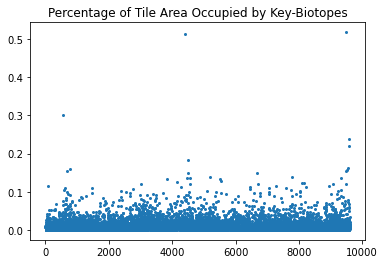

In [23]:
fig, ax = plt.subplots()

ax.scatter(x= np.arange(len(ratio)), y=ratio.Area.values, s = 4)
ax.set_title('Percentage of Tile Area Occupied by Key-Biotopes')

In [24]:
types = intersection_gdf.loc[:, ['square', 'BioGrp1', 'BioGrp2', 'BioGrp3']].set_index(['square'])

stacked = types.stack()

grouped = stacked.groupby('square')

habitats_numbers = grouped.nunique()

habitats_numbers

square
61375_4075_25    1
61425_4175_25    3
61425_4300_25    1
61450_4175_25    1
61450_4200_25    1
                ..
73725_8700_25    1
73725_8725_25    3
73725_8750_25    2
73725_8775_25    1
73725_8800_25    1
Length: 9607, dtype: int64

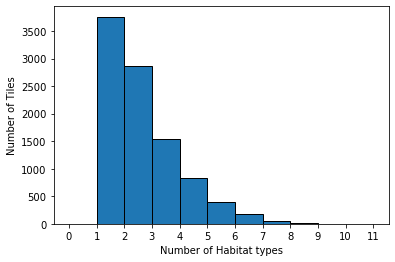

In [25]:
fig, ax = plt.subplots()

ax.hist(x= habitats_numbers.values, bins = range(12), rwidth = 1, edgecolor = 'k')
ax.set_xticks(range(12))
ax.set_xlabel('Number of Habitat types')
ax.set_ylabel('Number of Tiles')
plt.show()

In [26]:
def split_by_habitat(geoDF, habitat):
    return geoDF[(geoDF.BioGrp1 == habitat)|(geoDF.BioGrp2 == habitat)|(geoDF.BioGrp3 == habitat)]


def ratios(geoDF, habitat):
    grouped = split_by_habitat(geoDF, habitat).loc[:, ['square', 'Area']].groupby('square').sum()/TILE_AREA
    return grouped


habitat_groups = ['Barrskogar', 'Barrsumpskogar', 'Brandfält', 'Hagmarker', 'Kalkmarksskogar', 'Lundar', 'Lövsumpskogar', 
                  'Skogsbete', 'Topografiska', 'Triviallövskogar', 'Vatten', 'Ädellövskogar']

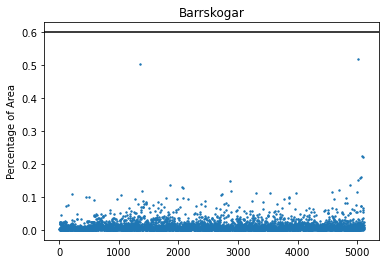

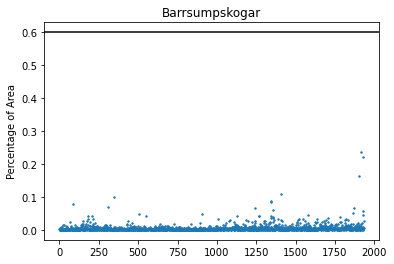

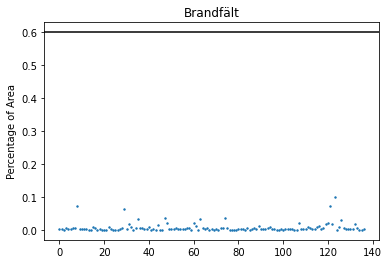

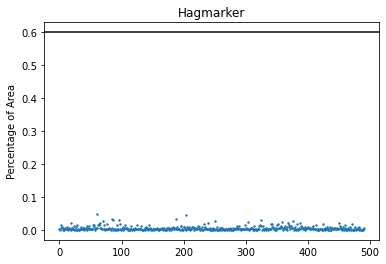

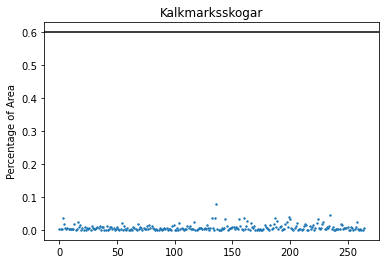

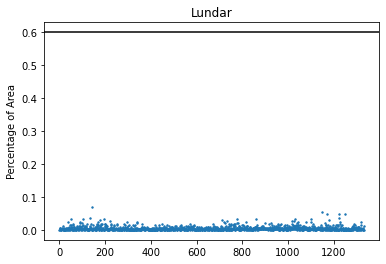

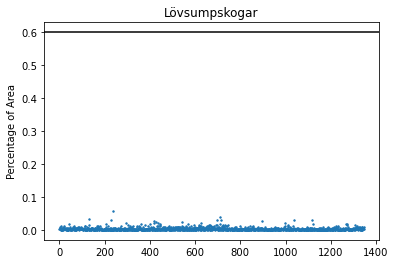

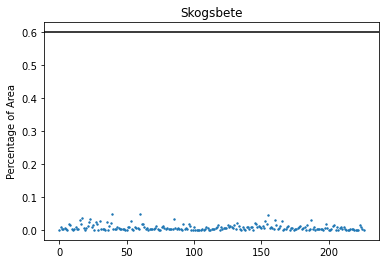

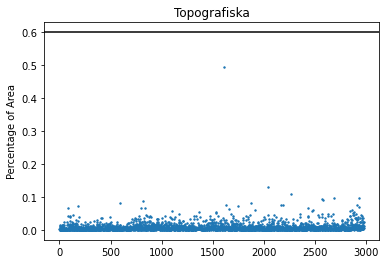

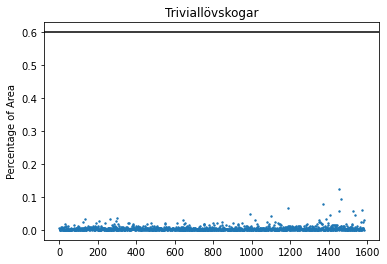

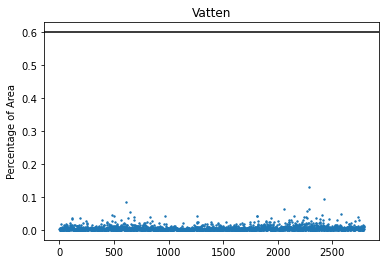

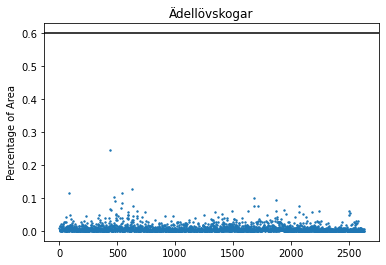

In [27]:
for habitat in habitat_groups:
    l = ratios(intersection_gdf, habitat)
    
    fig, ax = plt.subplots()
    ax.scatter(x= np.arange(len(l)), y=l.Area.values, s=2)
    ax.axhline(y=0.6, color= 'k')
    ax.set_title(habitat)
    ax.set_ylabel('Percentage of Area')